# NLP Hotel Review


In [1]:
#conda install -c conda-forge imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler    #sets min to zero, max to 1.
from sklearn.preprocessing import StandardScaler  #sets data to Z-scores
from sklearn.preprocessing import RobustScaler    # new, see below
from sklearn.decomposition import PCA
from sklearn import svm


from sklearn.neighbors import KNeighborsClassifier   # non-linear classifier

In [3]:
import re
import string

# SK Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK
import nltk

import warnings
warnings.filterwarnings('ignore')

In [4]:
# NLTK Packages
# Use the code below to download the NLTK package, a straightforward GUI should pop up
# nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [43]:
# metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve,classification_report, average_precision_score, auc

# SMOTE
from imblearn.over_sampling import SMOTE

In [7]:
df = pd.read_csv('/Users/stevekim/Desktop/python/NLP/Hotel_Reviews.csv')

In [8]:
df = df.sample(frac=0.1)

In [9]:
#top 5 rows only 'object' columns
df.select_dtypes('object').head()

,Negative_Review,Positive_Review
419954,I thought breakfast was included in my bookin...,Staff very helpful and friendly
144087,No face cloths hotel didn t umbrellas for loa...,Great location to take train to Paris great b...
174115,Old rooms with climatisation not working Need...,Very good location very nice staff very good ...
88401,My friend fell entering the terrace for tea a...,The bellman concierge and taxi fetcher were v...
372449,Access for a mobility scooter Too few teabags...,Bedrooms amazing Staff especially concierge a...


In [10]:
X = df.drop(columns=['Reviewer_Score'])
y = df['Reviewer_Score']

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.33)
#train and test entire dataset


In [16]:
stop_words = stopwords.words('english')

def my_tokenizers(document, lemmatization=False, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document
    '''
    # remove punctuation
    for punct in string.punctuation:
        document=document.replace(punct,'')

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]

    if stemming==True:
        stemmed_tokens_list = []
        for i in tokenized_document:
            token = PorterStemmer().stem(i)
            stemmed_tokens_list.append(token)
        return stemmed_tokens_list

    if lemmatization==True:
        lemmatized_tokens_list = []
        for i in tokenized_document:
            token = WordNetLemmatizer().lemmatize(i)
            lemmatized_tokens_list.append(token)
        return lemmatized_tokens_list

    return tokenized_document

In [63]:
# 1. Instantiate
bagofwords_positive = CountVectorizer(tokenizer=my_tokenizers, min_df =10, max_features=500)# limit to 500 and mindf= 10
#pass the tokenizer

# 2. Fit for both positive and negative reviews
bagofwords_positive.fit(X_train['Positive_Review'])


# 3. Transform X_train and X_test using the fitted CountVectorizer object
X_train_transformed_positive = bagofwords_positive.transform(X_train['Positive_Review'])
X_test_transformed_positive = bagofwords_positive.transform(X_test['Positive_Review'])


# Preview the shape of the transformed matrices
print(X_train_transformed_positive.shape)
print(X_test_transformed_positive.shape)


(34554, 500)
(17020, 500)


In [64]:
# 1. Instantiate
bagofwords_negative = CountVectorizer(tokenizer=my_tokenizers, min_df =10, max_features=500)# limit to 500 and mindf= 10
#pass the tokenizer

# 2. Fit for negative reviews
bagofwords_negative.fit(X_train['Negative_Review'])


# 3. Transform X_train and X_test using the fitted CountVectorizer object
X_train_transformed_negative = bagofwords_negative.transform(X_train['Negative_Review'])
X_test_transformed_negative = bagofwords_negative.transform(X_test['Negative_Review'])

# Preview the shape of the transformed matrices
print(X_train_transformed_negative.shape)
print(X_test_transformed_negative.shape)


(34554, 500)
(17020, 500)


In [65]:

# Convert transformed train and test data to array and set into dataframe for positive
train_positive = pd.DataFrame(data = X_train_transformed_positive.toarray(),columns = bagofwords_positive.get_feature_names_out(),index = X_train.index)
test_positive = pd.DataFrame(data = X_test_transformed_positive.toarray(),columns = bagofwords_positive.get_feature_names_out(),index = X_test.index)


# Convert transformed train and test data to array and set into dataframe for positive
train_negative = pd.DataFrame(data = X_train_transformed_negative.toarray(), columns= bagofwords_negative.get_feature_names_out(),index = X_train.index)
test_negative = pd.DataFrame(data = X_test_transformed_negative.toarray(), columns= bagofwords_negative.get_feature_names_out(),index = X_test.index)

#Add prefix to the column for negative  train and test 
train_negative = train_negative.add_prefix('neg_')
test_negative = test_negative.add_prefix('neg_')

#Add prefix to the column for positive  train and test 
train_positive = train_positive.add_prefix('pos_')
test_positive = test_positive.add_prefix('pos_')

#Combine with the original DataFrames
X_train_add_pos_neg = pd.concat([X_train, train_positive, train_negative], axis=1)
X_test_add_pos_neg = pd.concat([X_test, test_positive, test_negative], axis=1)

#X_train_add_pos_neg = X_train_add_pos_neg.drop(X_train)
#X_test_add_pos_neg = X_train_add_pos_neg.drop(X_test)
#you can do: table_name.drop(columns=[‘revscore’,’unnamed’], inplace=True) or .drop([‘revscore’,’unnamed’], axis=1)
#X_train_add_pos_neg.drop(columns=['Reviewer_Score', 'Unnamed: 0'], inplace=True)

X_train_add_pos_neg.drop(columns=['Unnamed: 0'], inplace=True)
X_test_add_pos_neg.drop(columns=['Unnamed: 0'], inplace=True)
#drop unnamed and original df['Review']

#drop the original positive and negative text columns
X_train_add_pos_neg.drop(columns=['Negative_Review','Positive_Review'], inplace=True)
X_test_add_pos_neg.drop(columns=['Negative_Review','Positive_Review'], inplace=True)





#X_train_add_pos_neg.drop(columns='X_train', inplace=True)
#X_test_add_pos_neg.drop(columns='X_train', inplace=True)
#.drop(columns='Reviewer_Score', inplace=True)

X_train_add_pos_neg.head()
X_test_add_pos_neg.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Days_Since_Review,Latitude,Longitude,Day,...,neg_wi,neg_wifi,neg_window,neg_without,neg_work,neg_worst,neg_worth,neg_would,neg_wrong,neg_year
87307,660,8.4,0,2902,44,3,210,51.493980,-0.143372,5,...,0,0,0,0,0,0,0,0,0,0
229589,116,7.2,5,1201,0,1,721,48.888539,2.349846,13,...,0,0,0,0,0,0,0,0,0,0
240920,359,8.5,4,1158,22,3,422,51.507720,0.022981,7,...,0,0,0,0,0,0,0,0,0,0
71706,274,8.6,10,924,25,1,148,51.477858,-0.013746,8,...,0,0,0,0,0,0,0,1,0,0
210611,364,7.1,9,1877,4,3,640,51.536605,-0.191983,2,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#use pd.dataFrame add back the negative and positive review scores and drop the original data


In [67]:
#Positive Review - Logistic Regression to predict positive review
logreg_pos_neg = LogisticRegression(C = 0.1)
logreg_pos_neg.fit(X_train_add_pos_neg, y_train)

print(f"Train Score for positive and negative review: {logreg_pos_neg.score(X_train_add_pos_neg, y_train)}")
print(f"Test Score for positive and negative review: {logreg_pos_neg.score(X_test_add_pos_neg, y_test)}")

Train Score for positive and negative review: 0.7334896104647798
Test Score for positive and negative review: 0.7363689776733255


In [28]:
# Negative Review - Logistic Regression to predict negative review
logreg_negative = LogisticRegression(C = 0.1) #regularize
logreg_negative.fit(X_train_transformed_negative,y_train)

# X_train_add_pos_neg 

#Training and test score
print(f"Train Score for negative review: {logreg_negative.score(X_train_transformed_negative, y_train)}") #X_train_add_pos_neg
print(f"Test Score for negative review: {logreg_negative.score(X_test_transformed_negative, y_test)}") # X_train_add_pos_neg test

Train Score for negative review: 0.7485095792093535
Test Score for negative review: 0.741069330199765


In [29]:
#Positive Review - Logistic Regression to predict positive review
logreg_positive = LogisticRegression(C = 0.1)
logreg_positive.fit(X_train_transformed_positive, y_train)

print(f"Train Score for positive review: {logreg_positive.score(X_train_transformed_positive, y_train)}")
print(f"Test Score for positive review: {logreg_positive.score(X_test_transformed_positive, y_test)}")

Train Score for positive review: 0.7154309197198587
Test Score for positive review: 0.7035252643948297


Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

In [30]:
#coefDf = pd.DataFrame({'variable':model.feature_names_in_, 'coef':model.coef_[0]}) #use this to extract the relevant information from logistic regrssion model

In [68]:
coef_neg = pd.DataFrame({'variable': bagofwords_negative.get_feature_names_out(), 'coef': logreg_negative.coef_[0]})
#feature name not the bagofwords
coef_pos = pd.DataFrame({'variable': bagofwords_positive.get_feature_names_out(), 'coef': logreg_positive.coef_[0]})


coef_pos_neg = pd.DataFrame({'variable': X_train_add_pos_neg.columns(), 'coef': X_train_add_pos_neg.coef_[0]})
#X_train_add_pos_neg









top20_neg = coef_neg.sort_values(by='coef', ascending=True).head(20)
print("\nTop 20 words predictive of Negative Sentiment:\n")
print(top20_neg)


top20_pos = coef_pos.sort_values(by='coef', ascending=False).head(20)
print("\nTop 20 words predictive of Positive Sentiment:\n")
coef_pos

#print(coef_pos2)

TypeError: 'Index' object is not callable

In [69]:
coef_neg = pd.DataFrame({'variable': bagofwords_negative.get_feature_names_out(), 'coef': logreg_negative.coef_[0]})
#feature name not the bagofwords
coef_pos = pd.DataFrame({'variable': bagofwords_positive.get_feature_names_out(), 'coef': logreg_positive.coef_[0]})


coef_pos_neg = pd.DataFrame({'variable': X_train_add_pos_neg.columns(), 'coef': X_train_add_pos_neg.coef_[0]})
#X_train_add_pos_neg



TypeError: 'Index' object is not callable

In [70]:
coef_pos_neg

,variable,coef
0,Additional_Number_of_Scoring,0.001316
1,Average_Score,0.184647
2,Review_Total_Negative_Word_Counts,-0.043206
3,Total_Number_of_Reviews,-0.000277
4,Review_Total_Positive_Word_Counts,0.047146
...,...,...
1021,neg_worst,-0.001076
1022,neg_worth,-0.001784
1023,neg_would,0.017890
1024,neg_wrong,-0.000243


In [34]:
#coef_pos_neg[coef_pos_neg['variable'].str.contains('pos_')].head(20).sort_values(by='coef', ascending=True)

In [72]:
# Assuming you have already trained your logistic regression model (logreg_pos_neg)
# and have the transformed dataframes (train_positive, test_positive, train_negative, test_negative)

# Create a DataFrame for coefficients
coef_all = pd.DataFrame({'variable': X_train_add_pos_neg.columns, 'coef': logreg_pos_neg.coef_[0]})

# Extract coefficients related to positive and negative sentiments
#coef_pos = coef_all.filter(like='pos_')
#coef_neg = coef_all.filter(like='neg_')

#top20_pos = coef_pos.iloc[abs(coef_pos['coef']).argsort()[::-1][:20]]

# Display the top 20 positive and negative coefficients
print("Top 20 Positive Coefficients:")
print(coef_pos)




Top 20 Positive Coefficients:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1026 rows x 0 columns]


In [73]:
coef_pos_neg = pd.DataFrame({'variable': X_train_add_pos_neg.columns, 'coef': logreg_pos_neg.coef_[0]})
#X_train_add_pos_neg
#print(coef_pos_neg)


top20 = coef_pos_neg.sort_values(by='coef', ascending=True).head(20)
# Extract coefficients related to positive and negative sentiments
#coef_pos = coef_pos_neg.filter(like='pos_')
#coef_neg = coef_pos_neg.filter(like='neg_')

# Get top 20 positive and negative coefficients
#top20_pos = coef_pos.loc[coef_pos['coef']].head(20)
#top20_neg = coef_neg.loc['coef'].head(20)

# Display the top 20 positive and negative coefficients
print("Top 20 Positive Coefficients:")

print(top20)

Top 20 Positive Coefficients:
                              variable      coef
896                           neg_room -0.094838
526                               neg_ -0.089863
7                             Latitude -0.058361
227                           pos_good -0.052114
17          Reviewer_Nationality_Other -0.051860
10                               Month -0.045337
927                          neg_small -0.043704
2    Review_Total_Negative_Word_Counts -0.043206
358                          pos_posit -0.027928
577                            neg_bed -0.021102
284                          pos_locat -0.018835
940                          neg_staff -0.018509
576                       neg_bathroom -0.017414
862                           neg_poor -0.015799
836                            neg_old -0.013642
437                        pos_station -0.013448
610                          neg_clean -0.012665
25                       Nights_Stayed -0.012452
20                Hotel_Address_London 

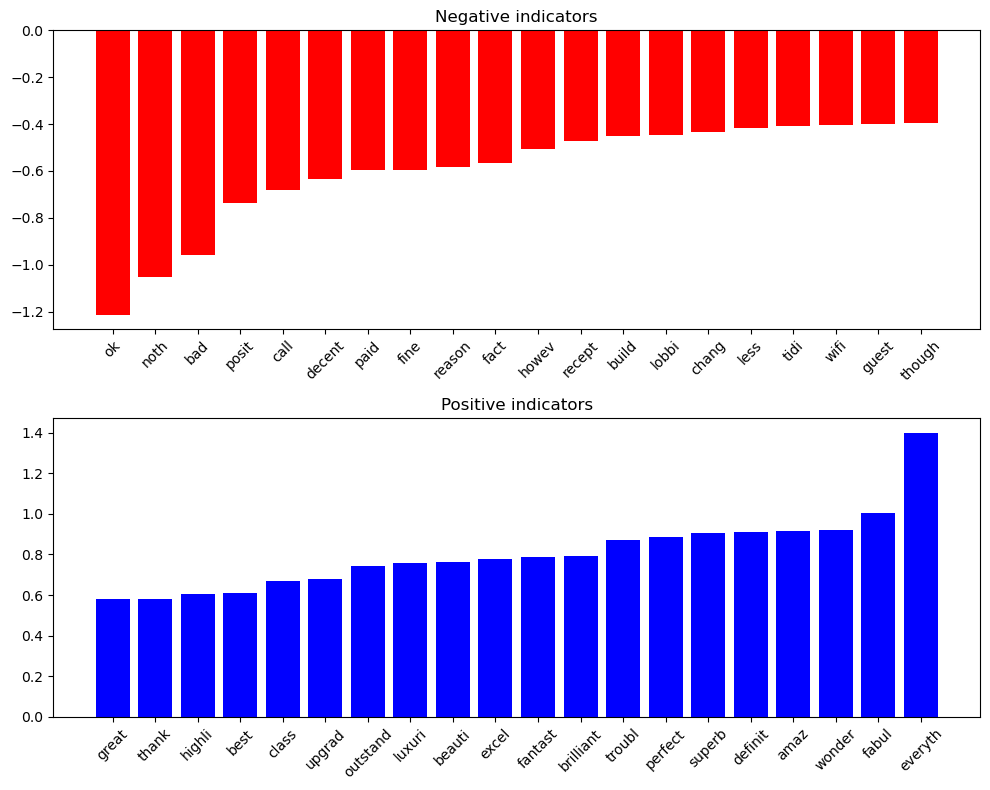

In [74]:
#Copy and mimic the Model Analysis from NLP_preprocessing_kick_off lecture

def plot_coefs(model, vectorizer):
    # Create a DataFrame to store the coefficients and corresponding tokens
    coef_df = pd.DataFrame({"variable": model.coef_[0], "coef": vectorizer.get_feature_names_out()})
    
    # Sort by coefficients
    coef_df = coef_df.sort_values("variable")

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot tokens indicating negative sentiment with smallest coefficients
    axs[0].bar(coef_df.head(20)["coef"], coef_df.head(20)["variable"], color="red")
    axs[0].set_xticklabels(coef_df.head(20)["coef"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens indicating positive sentiment with largest coefficients
    axs[1].bar(coef_df.tail(20)["coef"], coef_df.tail(20)["variable"], color="blue")
    axs[1].set_xticklabels(coef_df.tail(20)["coef"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()


plot_coefs(logreg_positive, bagofwords_positive)


Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.
Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
# Create a pipeline with PCA and Decision Tree Classifier
estimators = [
    ('normalise', StandardScaler()),
    ('reduce_dim', PCA()),
    ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

# Define the hyperparameter grid
param_grid = {
    'reduce_dim__n_components': [20],
    'model__max_depth': [1,2,3],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 10, 20] #minimum number of data points required on each leaf node
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv=5, error_score='raise')
fittedgrid = grid.fit(X_train_add_pos_neg, y_train)

#Best hyperparameters
print("Best hyperparameters:", fittedgrid.best_params_)


Best hyperparameters: {'model__max_depth': 3, 'model__min_samples_leaf': 20, 'model__min_samples_split': 20, 'reduce_dim__n_components': 20}


In [40]:
pred_logreg = logreg_pos_neg.predict(X_test_add_pos_neg)
pred_dt = fittedgrid.predict(X_test_add_pos_neg)

# Compare performance metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_logreg))
print("Decision Tree Accuracy:", accuracy_score(y_test, pred_dt))

Logistic Regression Accuracy: 0.7363689776733255
Decision Tree Accuracy: 0.7240305522914219


In [41]:
# Create a pipeline with PCA and Decision Tree Classifier
estimators = [
    ('normalise', StandardScaler()),
    ('reduce_dim', PCA()),
    ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

# Define the hyperparameter grid
param_grid_max_depth = { #different max_depth level
    'reduce_dim__n_components': [20],
    'model__max_depth': [3,5,10], #different max depth for decision tree
    'model__min_samples_split': [2, 5, 10, 20], #grid controls min number of samples required to split the node
    'model__min_samples_leaf': [1, 5, 10, 20] #minimum number of data points required on each leaf node
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid_max_depth, cv=5, error_score='raise')
fittedgrid = grid.fit(X_train_add_pos_neg, y_train)

#Best hyperparameters
print("Best hyperparameters:", fittedgrid.best_params_)


Best hyperparameters: {'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 20, 'reduce_dim__n_components': 20}


For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.

In [44]:
# Assuming fittedgrid is the best-performing model from your grid search
best_model = fittedgrid.best_estimator_

# Predictions on the test set
y_pred = best_model.predict(X_test_add_pos_neg)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[4963 2258]
 [2225 7574]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      7221
           1       0.77      0.77      0.77      9799

    accuracy                           0.74     17020
   macro avg       0.73      0.73      0.73     17020
weighted avg       0.74      0.74      0.74     17020



For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.

In [45]:
print('The absolute class distribution is:', f'\n{y.value_counts()}')
print(f'\nThe relative (%) class distribution is: \n{y.value_counts(normalize=True)*100}')

The absolute class distribution is: 
Reviewer_Score
1    29427
0    22147
Name: count, dtype: int64

The relative (%) class distribution is: 
Reviewer_Score
1    57.05782
0    42.94218
Name: proportion, dtype: float64


In [75]:
from sklearn.metrics import ConfusionMatrixDisplay

In [76]:
# Scaling using above features 
ss = StandardScaler().fit(X_train_add_pos_neg)
X_train_ss = ss.transform(X_train_add_pos_neg)
X_test_ss = ss.transform(X_test_add_pos_neg)

#instantiate and fit
logreg_ss = LogisticRegression().fit(X_train_add_pos_neg, y_train)

------------------------------------------
Accuracy score: 75.6%
Recall score: 73.0%
Precision score: 82.3%
F1 score: 0.77
------------------------------------------


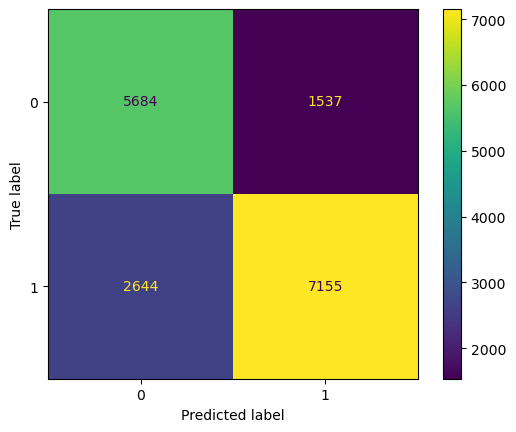

In [77]:
# predict classification
y_test_pred = logreg_ss.predict(X_test_ss)

print('------------------------------------------')

print(f'Accuracy score: {logregs.score(X_test_ss, y_test)*100:0.1f}%')
print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.1f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.1f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred):0.2f}')

print('------------------------------------------')


ConfusionMatrixDisplay.from_estimator(logreg_ss,X_test_ss, y_test); # optionally use normalize kwarg

Accuracy Score: 75.6%

This is the overall correct prediction rate. In your case, 75.6% of the reviews were correctly classified as either positive or negative.

Recall Score: 73.0%

Also known as Sensitivity or True Positive Rate. It's the percentage of actual positive instances (positive reviews) correctly predicted by the model. In your case, 73.0% of the actual positive reviews were correctly classified.

Precision Score: 82.3%

Precision is the number of true positives divided by the sum of true positives and false positives. It is a measure of the accuracy of the positive predictions. In your case, 82.3% of the predicted positive reviews were actually positive.

F1 Score: 0.77

The F1 Score is the harmonic mean of precision and recall. It is a balance between precision and recall. The F1 Score ranges from 0 to 1, where 1 is the best possible F1 Score. In your case, the F1 Score is 0.77, indicating a good balance between precision and recall.

In summary, your model has good accuracy, recall, precision, and F1 Score, suggesting that it performs reasonably well in classifying positive and negative reviews. The confusion matrix visualization would provide more insights into True Positive, True Negative, False Positive, and False Negative counts, but unfortunately, it's not available in the provided snippet.

True Positives (TP):
These are reviews that were correctly predicted as positive. In your case, the precision score indicates that around 82.3% of the predicted positive reviews were actually positive.
True Negatives (TN):
These are reviews that were correctly predicted as negative. Since precision and recall are more related to positive predictions, this information is not explicitly provided. However, it contributes to the overall accuracy score, which is 75.6%.
False Positives (FP):
These are reviews that were predicted as positive but were actually negative. Precision is sensitive to false positives, and the 17.7% error rate (100% - Precision) could indicate that there are some negative reviews misclassified as positive.
False Negatives (FN):
These are reviews that were predicted as negative but were actually positive. Recall is sensitive to false negatives, and the 27.0% recall score indicates that some actual positive reviews were missed by the model.
Precision-Recall Trade-off:
The precision and recall scores indicate a trade-off. A higher precision typically comes at the cost of lower recall, and vice versa. In your case, the precision score is higher than the recall score, suggesting a bias towards avoiding false positives.
F1 Score:
The F1 Score considers both precision and recall, providing a balance. A higher F1 Score indicates a better balance between avoiding false positives and false negatives. Your F1 Score of 0.77 is relatively good.
Overall Assessment:
The model performs well in terms of overall accuracy, precision, and F1 Score. However, it could be further analyzed to understand and potentially mitigate false positives and false negatives, depending on the specific business requirements.
To provide more detailed insights, it would be helpful to see the confusion matrix, which breaks down the counts of true positives, true negatives, false positives, and false negatives.

In [78]:
smote = SMOTE(random_state=1)


In [79]:
X_train_sm, y_train_sm = smote.fit_resample(X_train_add_pos_neg, y_train)

In [80]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Reviewer_Score
0    14926
1    19628
Name: count, dtype: int64


Resampled class distribution


Reviewer_Score
0    19628
1    19628
Name: count, dtype: int64

#### Scale


In [82]:
# scale the sampled train data and the unsampled test data
ss_sm = StandardScaler().fit(X_train_sm)
X_train_sm_ss = ss_sm.transform(X_train_sm)
X_test_ss_sm = ss_sm.transform(X_test_add_pos_neg)

**Note**: Why did we choose to perform the sampling in between the train-test split and the scaling?

- want to `fit_resample` just **train** and **not test data**
- want to `fit_resample` the original, unscaled features to preserve the data distribution

In [83]:
# instantiate and fit to scaled & sampled training data
logreg_sm = LogisticRegression(random_state=1, max_iter=15000).fit(X_train_sm_ss, y_train_sm)

Accuracy score: 78.5%
Recall score: 81.6%
Precision score: 81.2%
F1 score: 81.4%


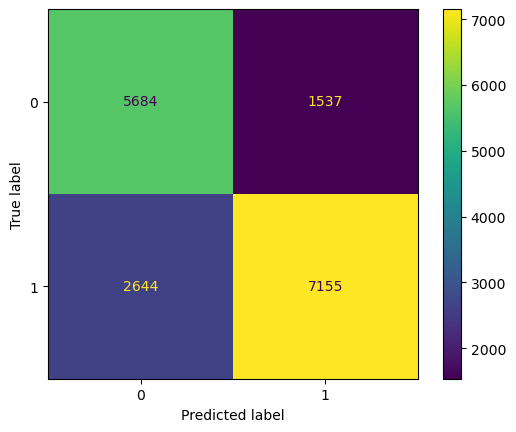

In [85]:
# predict classification
y_test_pred=logreg_sm.predict(X_test_ss_sm)

# confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg_ss,X_test_ss, y_test);

print(f'Accuracy score: {logreg_sm.score(X_test_ss_sm,y_test)*100:0.1f}%')
print(f'Recall score: {recall_score(y_test,y_test_pred)*100:0.1f}%')
print(f'Precision score: {precision_score(y_test,y_test_pred)*100:0.1f}%')
print(f'F1 score: {f1_score(y_test,y_test_pred)*100:0.1f}%')

| |recall|precision|f1|
|-|------|---------|--|
|**logreg on unsampled data**|73.0%|82.3%|0.77%|
|**logreg on SMOTE-sampled data**|81.6%|81.2%|0.81%|

Training a logistic regression model on SMOTE-sampled training data provides an **increase in the recall**, but **the precision suffers greatly**.

Why is this?  Remember what SMOTE is doing - it is creating synthetic minority class data "within" the existing minority class data.  The model thus learns more about the minority class, but also develops a kind of bias towards it as the variance in the minority class has become magnified.  A high recall score indicates that a model is very confident in classifying all data points that are truly of the minority class, which is what we're interested in with this dataset (fraudulent credit card transactions).  So, if we achieve that, we might have to live with the low precision.

A business may assign dollar/pound amounts to a false positive (customer dissatisfaction) and false negative (missing a fraudulent occurance) to decide if precision or recall is more important. 

Remember the definition of precision: **of all the points that the model classified as positive (correctly *and* incorrectly), how many did the model *correctly* classify as positive?**  Also remember that the equation for precision contains FP in its denominator.  So, a low precision score indicates that we have many FPs!

### Things to Consider

- Effects of oversampling on the precision score
- SMOTE "draws" a boundary in $n$-dimensional space ($n$ being the number of features you have) that surrounds the minority class, then creates synthetic data points within that boundary.  What if incoming new data has data points of the positive class, but in the feature space they lie outside of that boundary?

Comparison:

The model trained on SMOTE-sampled data shows improvements in recall, indicating better identification of positive instances, which is often crucial in imbalanced datasets.
The precision is still relatively high, indicating that the model maintains a good level of accuracy in predicting positive instances without excessively classifying negatives as positives.
The F1 score, being a combination of precision and recall, shows a balanced performance, considering both false positives and false negatives.
In summary, using SMOTE sampling appears to have enhanced the model's ability to correctly identify positive instances, leading to a more balanced and effective classification model.

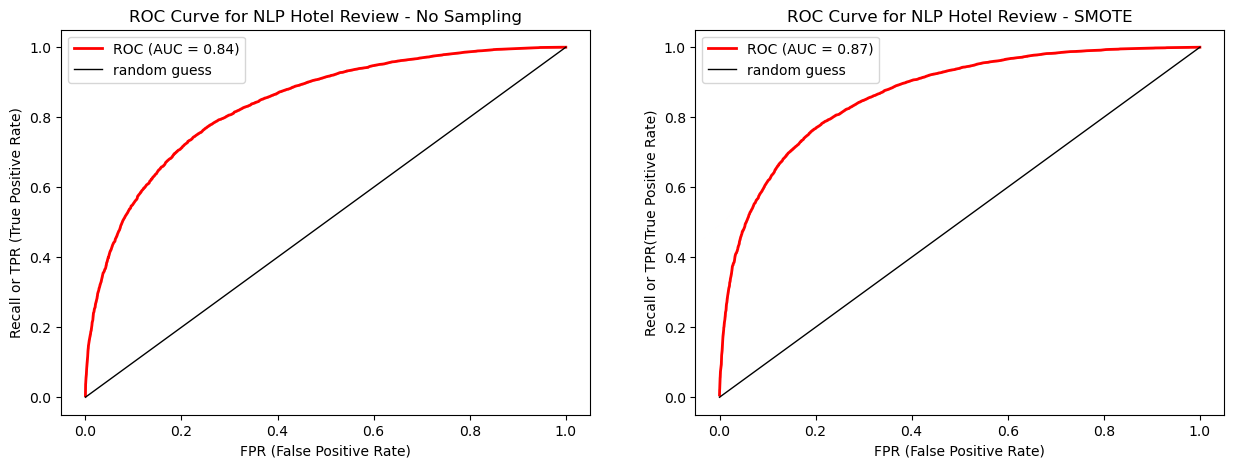

In [89]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)

# probabilistic prediction
y_test_proba = logreg_ss.predict_proba(X_test_ss)[:,1] # probabilities of data points being in the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
sns.lineplot(x=fpr, y=tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=1, label='random guess') # random guess
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('Recall or TPR (True Positive Rate)')
plt.title('ROC Curve for NLP Hotel Review - No Sampling')
plt.legend(loc='best')


plt.subplot(1,2,2)
# probabilistic prediction
y_test_proba_sm = logreg_sm.predict_proba(X_test_ss_sm)[:,1]

fpr_sm, tpr_sm, thresholds = roc_curve(y_test, y_test_proba_sm)
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

sns.lineplot(x=fpr_sm, y=tpr_sm, color='red', lw=2, label=f'ROC (AUC = {roc_auc_sm:0.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=1, label='random guess') # random guess
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('Recall or TPR(True Positive Rate)')
plt.title('ROC Curve for NLP Hotel Review - SMOTE')
plt.legend(loc="best")

plt.show()

Remember what the threshold is - if the probabilistic prediction of a data point being in the positive class is at or greater than x threshold, then our hard classifier will assign that data point to the positive class.  e.g. if our threshold is 0.3, and the probability of a data point being in the positive class is 0.4, then the hard classification is that the data point is positive.

Remember what the ROC curve represents - "if I were to set my threshold at x, then our model would have a TPR of y, but we would have to live with an FPR of z".
- **A threshold of 0 is the point at the top right of the ROC curve** - we are intentionally classifying every data point as positive, thus we correctly classify all the true positive data points ($TPR = 100\%$) but fail to correctly classify any of the true negative data points ($FPR = 100\%$)
- **A threshold of 1 is the point at the bottom left of the curve** - we are intentionally classifying every data point as negative, thus we correctly classify all the true negative data points ($FPR = 0\%$) but fail to correctly classify any of the true positive data points ($TPR = 0\%$)

In [90]:
# probabilistic prediction
y_test_proba = logreg_ss.predict_proba(X_test_ss)[:,1] # probabilities of data points being in the positive class
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f'ROC-AUC with no sampling -- {roc_auc:.4f}')

y_test_proba_sm = logreg_sm.predict_proba(X_test_ss_sm)[:,1] # probabilities of data points being in the positive class
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)
print(f'ROC-AUC with SMOTE -- {roc_auc_sm:.4f}')

ROC-AUC with no sampling -- 0.8381
ROC-AUC with SMOTE -- 0.8666



The ROC for both models has the same AUC - this is why it's important to evaluate your models using all applicable metrics. 
* AUC-ROC performs the best when the costs of false positives and false negatives are relatively similar, and there is no strong preference for improving one at the expense of the other. In our case, we prioritise the cost of a false negative over the cost of a false positive. Hence, AUC-ROC is likely not be a good metric of choice. 
* Additionally, AUC-ROC can provide misleading results when the class distribution is extremely skewed, in which case precision-recall curve is more useful

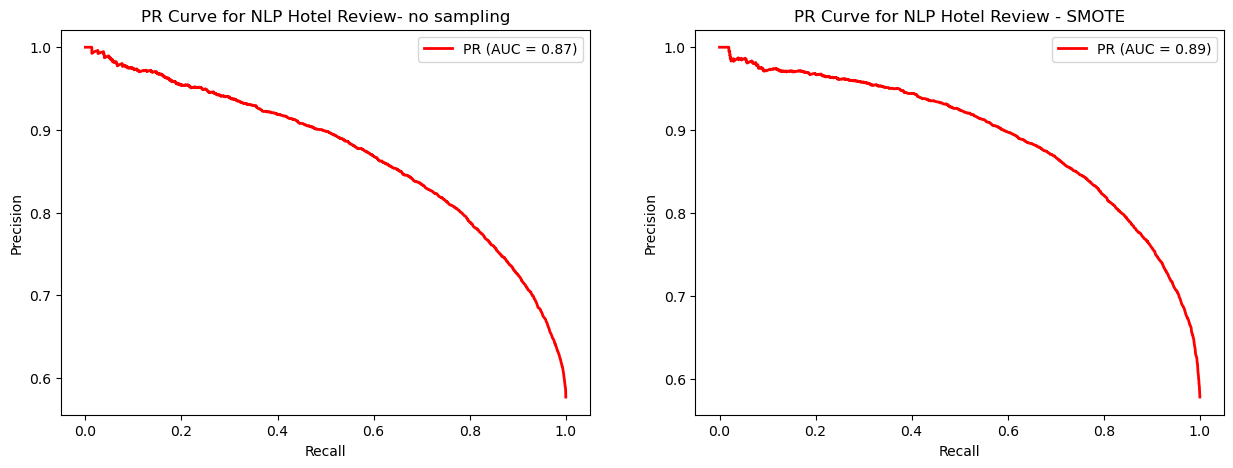

In [93]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)

# probabilistic prediction
y_test_proba = logreg_ss.predict_proba(X_test_ss)[:,1] # probabilities of data points being in the positive class

# ROC arrays
precision_, recall_, thresholds_ = precision_recall_curve(y_test, y_test_proba)

# auc precision-recall
aucpr = auc(recall_, precision_)

sns.lineplot(x=recall_, y=precision_, color='red', lw=2, label=f'PR (AUC = {auc(recall_, precision_):0.2f})')
# sns.lineplot([0, 1], [0, 1], color='black', lw=2, label='random guess') # random guess
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for NLP Hotel Review- no sampling')
plt.legend(loc='best')

plt.subplot(1,2,2)

# probabilistic prediction
y_test_proba_sm = logreg_sm.predict_proba(X_test_ss_sm)[:,1] # probabilities of data points being in the positive class

# ROC arrays
precision_sm, recall_sm, thresholds_ = precision_recall_curve(y_test, y_test_proba_sm)
# auc precision-recall
aucpr_sm = auc(recall_sm, precision_sm)

sns.lineplot(x=recall_sm, y=precision_sm, color='red', lw=2, label=f'PR (AUC = {auc(recall_sm, precision_sm):0.2f})')
# sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, label='random guess') # random guess
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for NLP Hotel Review - SMOTE')
plt.legend(loc='best')

plt.show()

PR-AUC increased after applying SMOTE from 0.87 to 0.89, which indicates that after SMOTE model's recall and precision improved, pointing towards the effectiveness of SMOTE in addressing class imbalance and improving the model's predictive capabilities for the minority class. 

PR-AUC (Precision-Recall Area Under the Curve) is a metric that measures the area under the precision-recall curve. It provides a summary of a model's performance across various levels of precision and recall.

In your case, you mentioned that PR-AUC increased from 0.87 to 0.89 after applying SMOTE. Here's an explanation of what this change indicates:

Improved Model Performance:
The Precision-Recall curve represents the trade-off between precision and recall at different probability thresholds.
An increase in PR-AUC from 0.87 to 0.89 suggests that the model's performance has improved after applying SMOTE.
Better Handling of Class Imbalance:
The improvement in PR-AUC indicates that SMOTE has been effective in addressing class imbalance.
Class imbalance occurs when there is a significant difference in the number of instances between the minority and majority classes.
SMOTE helps in oversampling the minority class, providing the model with more examples to learn from.
Enhanced Recall and Precision:
Recall and precision are crucial metrics, especially in imbalanced datasets.
Recall (sensitivity) measures the ability of the model to capture instances of the minority class, while precision measures the accuracy of the positive predictions.
An increase in PR-AUC suggests that both recall and precision have improved.
Overall Predictive Capabilities:
The higher PR-AUC after applying SMOTE indicates that the model's predictive capabilities for the minority class have been enhanced.
It suggests that the model is now better at identifying positive instances while maintaining high precision.
In summary, the increase in PR-AUC from 0.87 to 0.89 after applying SMOTE suggests an overall improvement in the model's ability to handle class imbalance, resulting in better recall and precision for the minority class. This is a positive outcome, indicating that SMOTE has contributed to the model's effectiveness in predicting instances of the minority class.

In [ ]:
df['id'] = df.groupby(['Latitude', 'Longitude']).ngroup()